# Preprocessing

In [ ]:
!pip install cairosvg py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00


TU Berlin

In [ ]:
import os
import zipfile
import cairosvg
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import io

# Constants
ARCHIVE_PATH = "sketches_svg.zip"
EXTRACT_DIR = "."
SVG_ROOT = os.path.join(EXTRACT_DIR, "svg")
OUTPUT_DIR = "processed_tuberlin"
IMG_SIZE = (224, 224)

def unzip_zip(zip_path, extract_to):
    print(f"[INFO] Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"[INFO] Extraction complete at {extract_to}")

def convert_svg_to_png(svg_path, png_path, size=IMG_SIZE):
    # Render SVG to bytes
    png_data = cairosvg.svg2png(
        url=str(svg_path),
        output_width=size[0],
        output_height=size[1]
    )

    image = Image.open(io.BytesIO(png_data)).convert("RGBA")
    white_bg = Image.new("RGBA", image.size, (255, 255, 255, 255))
    white_bg.paste(image, mask=image.split()[3])  # Use alpha channel as mask

    # save
    white_bg.convert("RGB").save(png_path, "PNG")

def preprocess_tuberlin_data(src_root, output_root):
    if not os.path.exists(src_root):
        raise FileNotFoundError(f"[ERROR] Dataset folder not found at: {src_root}")

    os.makedirs(output_root, exist_ok=True)
    classes = [d for d in os.listdir(src_root) if os.path.isdir(os.path.join(src_root, d))]

    for class_name in tqdm(classes, desc="Processing TU-Berlin classes"):
        class_dir = os.path.join(src_root, class_name)
        out_class_dir = os.path.join(output_root, class_name)
        os.makedirs(out_class_dir, exist_ok=True)

        for file in os.listdir(class_dir):
            if not file.endswith(".svg"):
                continue
            src_svg = os.path.join(class_dir, file)
            dst_png = os.path.join(out_class_dir, Path(file).stem + ".png")
            try:
                convert_svg_to_png(src_svg, dst_png)
            except Exception as e:
                print(f"[ERROR] Failed to convert {src_svg}: {e}")

if __name__ == "__main__":
    # extract
    if not os.path.exists(SVG_ROOT):
        unzip_zip(ARCHIVE_PATH, EXTRACT_DIR)

    # convert svg -> png
    preprocess_tuberlin_data(SVG_ROOT, OUTPUT_DIR)
    print(f"[INFO] Preprocessing complete. Images saved in: {OUTPUT_DIR}")


[INFO] Extracting sketches_svg.zip...
[INFO] Extraction complete at .


Processing TU-Berlin classes:  92%|█████████▏| 230/250 [04:15<00:19,  1.03it/s]

[ERROR] Failed to convert ./svg/cigarette/4262.svg: invalid literal for int() with base 10: 'C'


Processing TU-Berlin classes: 100%|██████████| 250/250 [04:38<00:00,  1.11s/it]

[INFO] Preprocessing complete. Images saved in: processed_tuberlin


Sketchy

In [ ]:
import os
import py7zr
import cairosvg
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import io

# Constants
ARCHIVE_PATH = "sketches-06-04.7z"
EXTRACT_DIR = "."
SKETCH_DIR = os.path.join(EXTRACT_DIR, "sketches")
OUTPUT_DIR = "processed_sketchy"
IMG_SIZE = (224, 224)

def unzip_7z(archive_path, extract_to):
    print(f"[INFO] Extracting {archive_path}...")
    with py7zr.SevenZipFile(archive_path, mode='r') as z:
        z.extractall(path=extract_to)
    print(f"[INFO] Extraction completed at {extract_to}")

def load_invalid_set(class_dir):
    invalid_file = os.path.join(class_dir, "invalid.txt")
    if os.path.exists(invalid_file):
        with open(invalid_file, 'r') as f:
            return set(line.strip() for line in f.readlines())
    return set()

def convert_svg_to_png(svg_path, png_path, size=IMG_SIZE):
    # Render SVG to PNG bytes
    png_data = cairosvg.svg2png(
        url=str(svg_path),
        output_width=size[0],
        output_height=size[1]
    )


    image = Image.open(io.BytesIO(png_data)).convert("RGBA")
    white_bg = Image.new("RGBA", image.size, (255, 255, 255, 255))
    white_bg.paste(image, mask=image.split()[3])  # Use alpha channel
    white_bg.convert("RGB").save(png_path, "PNG")

def preprocess_sketchy_data(src_root, output_root):
    if not os.path.exists(src_root):
        raise FileNotFoundError(f"[ERROR] Dataset folder not found at: {src_root}")

    os.makedirs(output_root, exist_ok=True)
    classes = [d for d in os.listdir(src_root) if os.path.isdir(os.path.join(src_root, d))]

    for class_name in tqdm(classes, desc="Processing classes"):
        class_dir = os.path.join(src_root, class_name)
        invalid_set = load_invalid_set(class_dir)
        out_class_dir = os.path.join(output_root, class_name)
        os.makedirs(out_class_dir, exist_ok=True)

        for file in os.listdir(class_dir):
            if not file.endswith('.svg'):
                continue
            file_stem = os.path.splitext(file)[0]
            if file_stem in invalid_set:
                continue

            src_svg = os.path.join(class_dir, file)
            dst_png = os.path.join(out_class_dir, file_stem + '.png')
            try:
                convert_svg_to_png(src_svg, dst_png)
            except Exception as e:
                print(f"[ERROR] Failed to convert {src_svg}: {e}")

if __name__ == "__main__":
    # extract
    if not os.path.exists(SKETCH_DIR):
        unzip_7z(ARCHIVE_PATH, EXTRACT_DIR)

    # svg -> png
    preprocess_sketchy_data(SKETCH_DIR, OUTPUT_DIR)
    print("[INFO] Preprocessing complete. Images saved in:", OUTPUT_DIR)


[INFO] Extracting sketches-06-04.7z...
[INFO] Extraction completed at .


Processing classes:   2%|▏         | 2/125 [00:17<17:37,  8.60s/it]

[ERROR] Failed to convert ./sketches/tiger/n02129604_8618-1.svg: no element found: line 86, column 0
[ERROR] Failed to convert ./sketches/tiger/n02129604_637-1.svg: no element found: line 53, column 0


Processing classes:   2%|▏         | 3/125 [00:37<28:17, 13.92s/it]

[ERROR] Failed to convert ./sketches/pizza/n07873807_6849-4.svg: no element found: line 55, column 0
[ERROR] Failed to convert ./sketches/pizza/n07873807_8839-3.svg: no element found: line 59, column 0
[ERROR] Failed to convert ./sketches/pizza/n07873807_8839-4.svg: no element found: line 38, column 0
[ERROR] Failed to convert ./sketches/pizza/n07873807_1597-3.svg: no element found: line 72, column 0
[ERROR] Failed to convert ./sketches/pizza/n07873807_2200-3.svg: no element found: line 48, column 0
[ERROR] Failed to convert ./sketches/pizza/n07873807_1257-4.svg: no element found: line 57, column 0
[ERROR] Failed to convert ./sketches/pizza/n07873807_11248-2.svg: no element found: line 47, column 0


Processing classes:   3%|▎         | 4/125 [00:56<31:48, 15.78s/it]

[ERROR] Failed to convert ./sketches/bat/n02139199_7674-4.svg: not well-formed (invalid token): line 51, column 86
[ERROR] Failed to convert ./sketches/bat/n02139199_7674-1.svg: not well-formed (invalid token): line 54, column 86
[ERROR] Failed to convert ./sketches/bat/n02139199_7674-5.svg: not well-formed (invalid token): line 41, column 86
[ERROR] Failed to convert ./sketches/bat/n02139199_7674-3.svg: not well-formed (invalid token): line 47, column 86
[ERROR] Failed to convert ./sketches/bat/n02139199_7674-2.svg: not well-formed (invalid token): line 57, column 86


Processing classes:   5%|▍         | 6/125 [01:16<24:57, 12.58s/it]

[ERROR] Failed to convert ./sketches/scorpion/n01770393_9723-1.svg: no element found: line 64, column 0
[ERROR] Failed to convert ./sketches/scorpion/n01770393_3338-2.svg: no element found: line 69, column 0
[ERROR] Failed to convert ./sketches/scorpion/n01770393_4534-1.svg: no element found: line 104, column 0
[ERROR] Failed to convert ./sketches/scorpion/n01770393_4227-3.svg: no element found: line 76, column 0
[ERROR] Failed to convert ./sketches/scorpion/n01770393_1301-5.svg: no element found: line 80, column 0
[ERROR] Failed to convert ./sketches/scorpion/n01770393_20648-4.svg: no element found: line 51, column 0


Processing classes:   6%|▋         | 8/125 [01:46<26:28, 13.58s/it]

[ERROR] Failed to convert ./sketches/rabbit/n02325366_7209-4.svg: no element found: line 45, column 0
[ERROR] Failed to convert ./sketches/rabbit/n02325366_2842-1.svg: no element found: line 51, column 0


Processing classes:   7%|▋         | 9/125 [01:58<25:04, 12.97s/it]

[ERROR] Failed to convert ./sketches/cow/n01887787_632-3.svg: no element found: line 60, column 0
[ERROR] Failed to convert ./sketches/cow/n01887787_2199-3.svg: no element found: line 71, column 0
[ERROR] Failed to convert ./sketches/cow/n01887787_1489-4.svg: no element found: line 71, column 0
[ERROR] Failed to convert ./sketches/cow/n01887787_1489-5.svg: no element found: line 49, column 0


Processing classes:   9%|▉         | 11/125 [02:25<24:34, 12.93s/it]

[ERROR] Failed to convert ./sketches/airplane/n02691156_3791-2.svg: no element found: line 71, column 0
[ERROR] Failed to convert ./sketches/airplane/n02691156_7989-2.svg: no element found: line 51, column 0


Processing classes:  12%|█▏        | 15/125 [03:16<23:54, 13.04s/it]

[ERROR] Failed to convert ./sketches/church/n03028079_29875-5.svg: not well-formed (invalid token): line 20, column 92


Processing classes:  15%|█▌        | 19/125 [04:17<26:28, 14.98s/it]

[ERROR] Failed to convert ./sketches/kangaroo/n01877134_1108-1.svg: no element found: line 55, column 0
[ERROR] Failed to convert ./sketches/kangaroo/n01877134_8285-3.svg: no element found: line 62, column 0
[ERROR] Failed to convert ./sketches/kangaroo/n01877134_7832-3.svg: no element found: line 61, column 0
[ERROR] Failed to convert ./sketches/kangaroo/n01877134_389-3.svg: no element found: line 51, column 0


Processing classes:  18%|█▊        | 22/125 [04:59<25:17, 14.73s/it]

[ERROR] Failed to convert ./sketches/banana/n07753592_6916-1.svg: no element found: line 39, column 0
[ERROR] Failed to convert ./sketches/banana/n07753592_12041-3.svg: no element found: line 36, column 0
[ERROR] Failed to convert ./sketches/banana/n07753592_11653-3.svg: no element found: line 55, column 0
[ERROR] Failed to convert ./sketches/banana/n07753592_11653-2.svg: no element found: line 38, column 0


Processing classes:  18%|█▊        | 23/125 [05:10<22:55, 13.49s/it]

[ERROR] Failed to convert ./sketches/owl/n01621127_2756-2.svg: no element found: line 45, column 0
[ERROR] Failed to convert ./sketches/owl/n01621127_4117-4.svg: no element found: line 70, column 0


Processing classes:  19%|█▉        | 24/125 [05:24<22:58, 13.65s/it]

[ERROR] Failed to convert ./sketches/butterfly/n02274259_6495-2.svg: no element found: line 56, column 0
[ERROR] Failed to convert ./sketches/butterfly/n02274259_19616-2.svg: no element found: line 45, column 0
[ERROR] Failed to convert ./sketches/butterfly/n02274259_12982-4.svg: no element found: line 59, column 0


Processing classes:  20%|██        | 25/125 [05:36<22:08, 13.28s/it]

[ERROR] Failed to convert ./sketches/camel/n02437136_1941-3.svg: no element found: line 111, column 0
[ERROR] Failed to convert ./sketches/camel/n02437136_4995-4.svg: no element found: line 52, column 0
[ERROR] Failed to convert ./sketches/camel/n02437136_666-3.svg: no element found: line 62, column 0


Processing classes:  21%|██        | 26/125 [05:50<22:12, 13.46s/it]

[ERROR] Failed to convert ./sketches/penguin/n02056570_4309-1.svg: not well-formed (invalid token): line 4, column 112
[ERROR] Failed to convert ./sketches/penguin/n02056570_4309-2.svg: not well-formed (invalid token): line 4, column 112
[ERROR] Failed to convert ./sketches/penguin/n02056570_4309-3.svg: not well-formed (invalid token): line 4, column 112
[ERROR] Failed to convert ./sketches/penguin/n02056570_4309-4.svg: not well-formed (invalid token): line 4, column 112
[ERROR] Failed to convert ./sketches/penguin/n02056570_4309-5.svg: not well-formed (invalid token): line 4, column 112


Processing classes:  23%|██▎       | 29/125 [06:23<19:37, 12.27s/it]

[ERROR] Failed to convert ./sketches/geyser/n09288635_1624-5.svg: not well-formed (invalid token): line 4, column 58
[ERROR] Failed to convert ./sketches/geyser/n09288635_1624-1.svg: not well-formed (invalid token): line 4, column 58
[ERROR] Failed to convert ./sketches/geyser/n09288635_1624-4.svg: not well-formed (invalid token): line 4, column 58
[ERROR] Failed to convert ./sketches/geyser/n09288635_1624-2.svg: not well-formed (invalid token): line 4, column 58
[ERROR] Failed to convert ./sketches/geyser/n09288635_1624-3.svg: not well-formed (invalid token): line 4, column 58


Processing classes:  26%|██▋       | 33/125 [07:12<19:12, 12.53s/it]

[ERROR] Failed to convert ./sketches/jellyfish/n01910747_2047-4.svg: not well-formed (invalid token): line 4, column 52
[ERROR] Failed to convert ./sketches/jellyfish/n01910747_2047-1.svg: not well-formed (invalid token): line 4, column 52
[ERROR] Failed to convert ./sketches/jellyfish/n01910747_2047-5.svg: not well-formed (invalid token): line 4, column 52
[ERROR] Failed to convert ./sketches/jellyfish/n01910747_2047-3.svg: not well-formed (invalid token): line 4, column 52
[ERROR] Failed to convert ./sketches/jellyfish/n01910747_2047-2.svg: not well-formed (invalid token): line 4, column 52


Processing classes:  28%|██▊       | 35/125 [07:38<19:07, 12.75s/it]

[ERROR] Failed to convert ./sketches/chicken/n01791625_8328-5.svg: no element found: line 52, column 0
[ERROR] Failed to convert ./sketches/chicken/n01791625_16957-2.svg: no element found: line 45, column 0
[ERROR] Failed to convert ./sketches/chicken/n01791625_9216-2.svg: no element found: line 59, column 0
[ERROR] Failed to convert ./sketches/chicken/n01791625_10056-1.svg: no element found: line 50, column 0
[ERROR] Failed to convert ./sketches/chicken/n01791625_10275-2.svg: no element found: line 52, column 0


Processing classes:  33%|███▎      | 41/125 [09:00<19:05, 13.64s/it]

[ERROR] Failed to convert ./sketches/bicycle/n02834778_53747-2.svg: no element found: line 69, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_12604-2.svg: no element found: line 62, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_11097-2.svg: no element found: line 48, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_6712-3.svg: no element found: line 125, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_642-4.svg: no element found: line 64, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_6092-4.svg: no element found: line 105, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_12430-2.svg: no element found: line 78, column 0
[ERROR] Failed to convert ./sketches/bicycle/n02834778_6092-2.svg: no element found: line 99, column 0


Processing classes:  35%|███▌      | 44/125 [09:40<17:22, 12.87s/it]

[ERROR] Failed to convert ./sketches/snail/n01944390_4350-1.svg: no element found: line 61, column 0
[ERROR] Failed to convert ./sketches/snail/n01944390_1204-2.svg: no element found: line 43, column 0


Processing classes:  36%|███▌      | 45/125 [09:51<16:32, 12.40s/it]

[ERROR] Failed to convert ./sketches/turtle/n01669191_4493-2.svg: no element found: line 86, column 0
[ERROR] Failed to convert ./sketches/turtle/n01669191_5982-4.svg: no element found: line 41, column 0
[ERROR] Failed to convert ./sketches/turtle/n01669191_8902-3.svg: no element found: line 114, column 0


Processing classes:  37%|███▋      | 46/125 [10:06<17:10, 13.05s/it]

[ERROR] Failed to convert ./sketches/axe/n02764044_9419-2.svg: no element found: line 41, column 0
[ERROR] Failed to convert ./sketches/axe/n02764044_41079-1.svg: no element found: line 35, column 0
[ERROR] Failed to convert ./sketches/axe/n02764044_24393-3.svg: no element found: line 32, column 0
[ERROR] Failed to convert ./sketches/axe/n02764044_23833-3.svg: no element found: line 33, column 0
[ERROR] Failed to convert ./sketches/axe/n02764044_21188-1.svg: no element found: line 38, column 0


Processing classes:  39%|███▉      | 49/125 [10:47<17:47, 14.05s/it]

[ERROR] Failed to convert ./sketches/pineapple/n07753275_14607-2.svg: no element found: line 125, column 0
[ERROR] Failed to convert ./sketches/pineapple/n07753275_23767-3.svg: no element found: line 59, column 0
[ERROR] Failed to convert ./sketches/pineapple/n07753275_24463-1.svg: no element found: line 74, column 0
[ERROR] Failed to convert ./sketches/pineapple/n07753275_16105-1.svg: no element found: line 45, column 0


Processing classes:  40%|████      | 50/125 [11:02<17:54, 14.33s/it]

[ERROR] Failed to convert ./sketches/sword/n04373894_27024-2.svg: no element found: line 59, column 0
[ERROR] Failed to convert ./sketches/sword/n04373894_56551-3.svg: no element found: line 39, column 0
[ERROR] Failed to convert ./sketches/sword/n04373894_27024-1.svg: no element found: line 48, column 0


Processing classes:  41%|████      | 51/125 [11:11<15:43, 12.75s/it]

[ERROR] Failed to convert ./sketches/bee/n02206856_3457-1.svg: no element found: line 44, column 0
[ERROR] Failed to convert ./sketches/bee/n02206856_617-3.svg: no element found: line 81, column 0
[ERROR] Failed to convert ./sketches/bee/n02206856_6708-1.svg: no element found: line 41, column 0
[ERROR] Failed to convert ./sketches/bee/n02206856_1111-2.svg: no element found: line 57, column 0


Processing classes:  43%|████▎     | 54/125 [11:50<15:47, 13.34s/it]

[ERROR] Failed to convert ./sketches/strawberry/n07745940_645-3.svg: no element found: line 61, column 0
[ERROR] Failed to convert ./sketches/strawberry/n07745940_9050-4.svg: no element found: line 56, column 0


Processing classes:  44%|████▍     | 55/125 [12:02<15:16, 13.10s/it]

[ERROR] Failed to convert ./sketches/chair/n03001627_15880-1.svg: no element found: line 53, column 0
[ERROR] Failed to convert ./sketches/chair/n03001627_5399-2.svg: no element found: line 43, column 0


Processing classes:  45%|████▍     | 56/125 [12:17<15:26, 13.43s/it]

[ERROR] Failed to convert ./sketches/table/n04379243_1127-2.svg: not well-formed (invalid token): line 4, column 61
[ERROR] Failed to convert ./sketches/table/n04379243_1127-3.svg: not well-formed (invalid token): line 4, column 61
[ERROR] Failed to convert ./sketches/table/n04379243_1127-1.svg: not well-formed (invalid token): line 4, column 61
[ERROR] Failed to convert ./sketches/table/n04379243_1127-4.svg: not well-formed (invalid token): line 4, column 61
[ERROR] Failed to convert ./sketches/table/n04379243_1127-5.svg: not well-formed (invalid token): line 4, column 61


Processing classes:  46%|████▌     | 57/125 [12:28<14:27, 12.76s/it]

[ERROR] Failed to convert ./sketches/sailboat/n04128499_13402-4.svg: no element found: line 44, column 0
[ERROR] Failed to convert ./sketches/sailboat/n04128499_7174-4.svg: no element found: line 54, column 0
[ERROR] Failed to convert ./sketches/sailboat/n04128499_4871-1.svg: no element found: line 38, column 0
[ERROR] Failed to convert ./sketches/sailboat/n04128499_13402-2.svg: no element found: line 63, column 0


Processing classes:  46%|████▋     | 58/125 [12:37<13:15, 11.87s/it]

[ERROR] Failed to convert ./sketches/couch/n04256520_31110-4.svg: no element found: line 51, column 0
[ERROR] Failed to convert ./sketches/couch/n04256520_11786-1.svg: no element found: line 42, column 0
[ERROR] Failed to convert ./sketches/couch/n04256520_8346-6.svg: not well-formed (invalid token): line 17, column 57


Processing classes:  48%|████▊     | 60/125 [13:03<13:05, 12.09s/it]

[ERROR] Failed to convert ./sketches/seagull/n02041246_11928-3.svg: no element found: line 59, column 0


Processing classes:  54%|█████▍    | 68/125 [14:51<12:56, 13.62s/it]

[ERROR] Failed to convert ./sketches/teapot/n04398044_14186-2.svg: no element found: line 57, column 0
[ERROR] Failed to convert ./sketches/teapot/n04398044_10719-1.svg: no element found: line 36, column 0
[ERROR] Failed to convert ./sketches/teapot/n04398044_17457-1.svg: no element found: line 109, column 0
[ERROR] Failed to convert ./sketches/teapot/n04398044_16629-2.svg: no element found: line 38, column 0


Processing classes:  55%|█████▌    | 69/125 [15:04<12:34, 13.48s/it]

[ERROR] Failed to convert ./sketches/squirrel/n02355227_14513-4.svg: no element found: line 53, column 0


Processing classes:  60%|██████    | 75/125 [16:16<09:41, 11.64s/it]

[ERROR] Failed to convert ./sketches/duck/n01846331_16017-1.svg: no element found: line 43, column 0
[ERROR] Failed to convert ./sketches/duck/n01846331_8946-3.svg: no element found: line 64, column 0


Processing classes:  62%|██████▏   | 78/125 [16:52<09:26, 12.05s/it]

[ERROR] Failed to convert ./sketches/wine_bottle/n04591713_1237-3.svg: no element found: line 45, column 0
[ERROR] Failed to convert ./sketches/wine_bottle/n04591713_4506-4.svg: no element found: line 39, column 0
[ERROR] Failed to convert ./sketches/wine_bottle/n04591713_7080-3.svg: no element found: line 48, column 0
[ERROR] Failed to convert ./sketches/wine_bottle/n04591713_3423-2.svg: no element found: line 39, column 0


Processing classes:  63%|██████▎   | 79/125 [17:01<08:23, 10.94s/it]

[ERROR] Failed to convert ./sketches/blimp/n02850950_13731-1.svg: no element found: line 48, column 0
[ERROR] Failed to convert ./sketches/blimp/n02850950_13429-3.svg: no element found: line 48, column 0
[ERROR] Failed to convert ./sketches/blimp/n02850950_14050-1.svg: no element found: line 48, column 0


Processing classes:  65%|██████▍   | 81/125 [17:20<07:36, 10.38s/it]

[ERROR] Failed to convert ./sketches/snake/n01726692_67-1.svg: no element found: line 118, column 0
[ERROR] Failed to convert ./sketches/snake/n01726692_1321-4.svg: no element found: line 93, column 0
[ERROR] Failed to convert ./sketches/snake/n01726692_9155-3.svg: no element found: line 41, column 0


Processing classes:  68%|██████▊   | 85/125 [18:08<07:27, 11.19s/it]

[ERROR] Failed to convert ./sketches/car_(sedan)/n04166281_1917-1.svg: no element found: line 66, column 0
[ERROR] Failed to convert ./sketches/car_(sedan)/n04166281_5506-1.svg: no element found: line 49, column 0


Processing classes:  70%|██████▉   | 87/125 [18:39<08:23, 13.26s/it]

[ERROR] Failed to convert ./sketches/cup/n03147509_12690-2.svg: no element found: line 33, column 0
[ERROR] Failed to convert ./sketches/cup/n03147509_13746-3.svg: no element found: line 41, column 0
[ERROR] Failed to convert ./sketches/cup/n03147509_11467-3.svg: no element found: line 38, column 0
[ERROR] Failed to convert ./sketches/cup/n03147509_21910-1.svg: no element found: line 34, column 0


Processing classes:  71%|███████   | 89/125 [18:58<06:46, 11.29s/it]

[ERROR] Failed to convert ./sketches/helicopter/n03512147_2566-4.svg: no element found: line 60, column 0
[ERROR] Failed to convert ./sketches/helicopter/n03512147_5-5.svg: no element found: line 55, column 0


Processing classes:  72%|███████▏  | 90/125 [19:13<07:15, 12.43s/it]

[ERROR] Failed to convert ./sketches/cat/n02121620_4315-2.svg: no element found: line 116, column 0


Processing classes:  74%|███████▎  | 92/125 [19:38<06:51, 12.46s/it]

[ERROR] Failed to convert ./sketches/motorcycle/n03790512_6771-3.svg: no element found: line 49, column 0
[ERROR] Failed to convert ./sketches/motorcycle/n03790512_11006-4.svg: no element found: line 84, column 0


Processing classes:  75%|███████▌  | 94/125 [20:07<06:40, 12.91s/it]

[ERROR] Failed to convert ./sketches/horse/n02374451_12792-4.svg: no element found: line 55, column 0


Processing classes:  76%|███████▌  | 95/125 [20:22<06:50, 13.69s/it]

[ERROR] Failed to convert ./sketches/dog/n02103406_3743-1.svg: no element found: line 100, column 0


Processing classes:  78%|███████▊  | 98/125 [21:06<06:20, 14.10s/it]

[ERROR] Failed to convert ./sketches/hot-air_balloon/n03541923_3937-4.svg: no element found: line 45, column 0
[ERROR] Failed to convert ./sketches/hot-air_balloon/n03541923_751-3.svg: no element found: line 52, column 0
[ERROR] Failed to convert ./sketches/hot-air_balloon/n03541923_1075-1.svg: no element found: line 40, column 0
[ERROR] Failed to convert ./sketches/hot-air_balloon/n03541923_751-5.svg: no element found: line 62, column 0


Processing classes:  82%|████████▏ | 103/125 [22:11<05:03, 13.77s/it]

[ERROR] Failed to convert ./sketches/knife/n03624134_19018-4.svg: no element found: line 32, column 0
[ERROR] Failed to convert ./sketches/knife/n03624134_9727-2.svg: no element found: line 33, column 0
[ERROR] Failed to convert ./sketches/knife/n03624134_16309-1.svg: no element found: line 34, column 0


Processing classes:  83%|████████▎ | 104/125 [22:20<04:19, 12.36s/it]

[ERROR] Failed to convert ./sketches/pig/n02395406_5730-4.svg: not well-formed (invalid token): line 4, column 50
[ERROR] Failed to convert ./sketches/pig/n02395406_5730-5.svg: not well-formed (invalid token): line 4, column 50
[ERROR] Failed to convert ./sketches/pig/n02395406_5730-3.svg: not well-formed (invalid token): line 4, column 50
[ERROR] Failed to convert ./sketches/pig/n02395406_5730-1.svg: not well-formed (invalid token): line 4, column 50
[ERROR] Failed to convert ./sketches/pig/n02395406_5730-2.svg: not well-formed (invalid token): line 4, column 50


Processing classes:  84%|████████▍ | 105/125 [22:32<04:06, 12.31s/it]

[ERROR] Failed to convert ./sketches/windmill/n04587404_1621-4.svg: not well-formed (invalid token): line 4, column 38
[ERROR] Failed to convert ./sketches/windmill/n04587404_1621-6.svg: not well-formed (invalid token): line 4, column 38
[ERROR] Failed to convert ./sketches/windmill/n04587404_1621-1.svg: not well-formed (invalid token): line 4, column 38
[ERROR] Failed to convert ./sketches/windmill/n04587404_1621-3.svg: not well-formed (invalid token): line 4, column 38


Processing classes:  85%|████████▍ | 106/125 [22:45<03:56, 12.47s/it]

[ERROR] Failed to convert ./sketches/windmill/n04587404_1621-2.svg: not well-formed (invalid token): line 4, column 38


Processing classes:  86%|████████▌ | 107/125 [22:58<03:49, 12.75s/it]

[ERROR] Failed to convert ./sketches/hotdog/n07697537_6515-2.svg: no element found: line 43, column 0
[ERROR] Failed to convert ./sketches/hotdog/n07697537_23978-3.svg: no element found: line 44, column 0
[ERROR] Failed to convert ./sketches/hotdog/n07697537_23978-2.svg: no element found: line 34, column 0


Processing classes:  88%|████████▊ | 110/125 [23:33<02:57, 11.84s/it]

[ERROR] Failed to convert ./sketches/hammer/n03481172_11270-2.svg: no element found: line 42, column 0
[ERROR] Failed to convert ./sketches/hammer/n03481172_8941-4.svg: no element found: line 44, column 0


Processing classes:  89%|████████▉ | 111/125 [23:41<02:30, 10.76s/it]

[ERROR] Failed to convert ./sketches/mouse/n02330245_6957-3.svg: no element found: line 71, column 0
[ERROR] Failed to convert ./sketches/mouse/n02330245_3319-2.svg: no element found: line 37, column 0
[ERROR] Failed to convert ./sketches/mouse/n02330245_9563-1.svg: no element found: line 65, column 0


Processing classes:  92%|█████████▏| 115/125 [24:30<02:05, 12.58s/it]

[ERROR] Failed to convert ./sketches/pickup_truck/n03930630_3633-5.svg: no element found: line 89, column 0
[ERROR] Failed to convert ./sketches/pickup_truck/n03930630_13293-2.svg: no element found: line 87, column 0
[ERROR] Failed to convert ./sketches/pickup_truck/n03930630_11510-1.svg: no element found: line 65, column 0


Processing classes:  93%|█████████▎| 116/125 [24:48<02:06, 14.08s/it]

[ERROR] Failed to convert ./sketches/pickup_truck/n03930630_4499-3.svg: no element found: line 43, column 0


Processing classes:  95%|█████████▌| 119/125 [25:18<01:09, 11.59s/it]

[ERROR] Failed to convert ./sketches/bear/n02131653_9118-3.svg: no element found: line 87, column 0


Processing classes:  97%|█████████▋| 121/125 [25:39<00:44, 11.01s/it]

[ERROR] Failed to convert ./sketches/candle/n02948072_1674-3.svg: not well-formed (invalid token): line 4, column 88
[ERROR] Failed to convert ./sketches/candle/n02948072_1674-1.svg: not well-formed (invalid token): line 4, column 88
[ERROR] Failed to convert ./sketches/candle/n02948072_1674-2.svg: not well-formed (invalid token): line 4, column 88
[ERROR] Failed to convert ./sketches/candle/n02948072_1674-4.svg: not well-formed (invalid token): line 4, column 88


Processing classes:  98%|█████████▊| 122/125 [25:47<00:29,  9.95s/it]

[ERROR] Failed to convert ./sketches/candle/n02948072_1674-5.svg: not well-formed (invalid token): line 4, column 88


Processing classes: 100%|██████████| 125/125 [26:25<00:00, 12.69s/it]

[INFO] Preprocessing complete. Images saved in: processed_sketchy



[INFO] EDA for Sketchy Dataset
Total Classes: 125
Total Images: 64393

Top 5 classes by image count:
               Class  Image Count
6                axe          555
110           teapot          555
79            rabbit          554
56            hotdog          552
55   hot-air_balloon          551


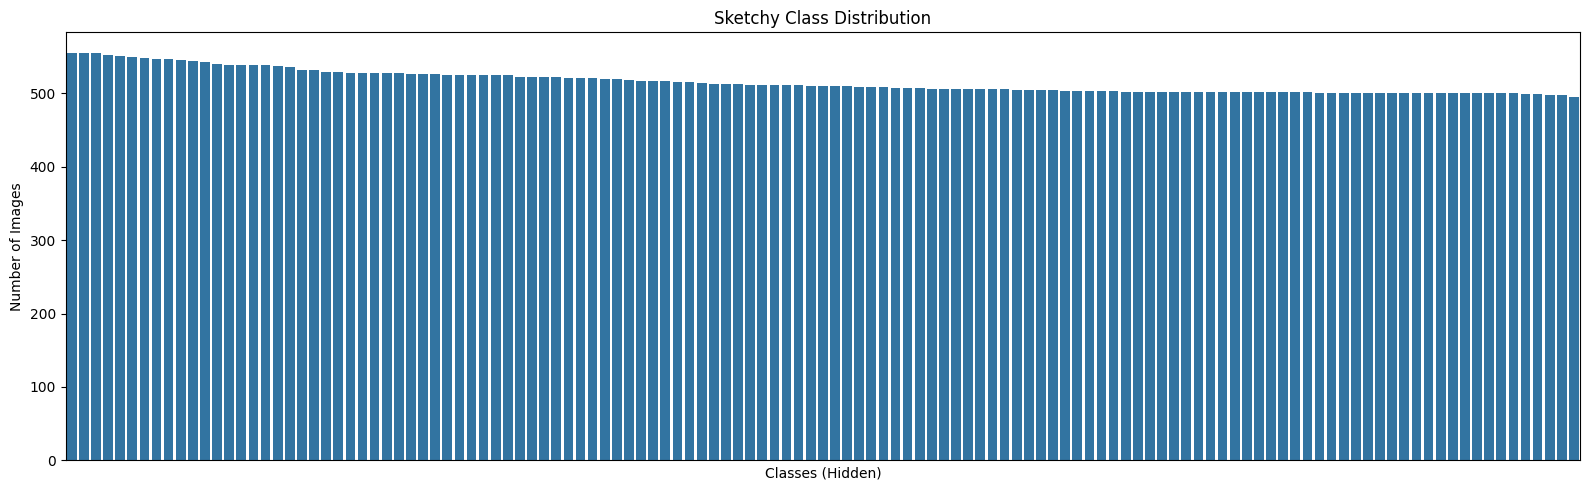

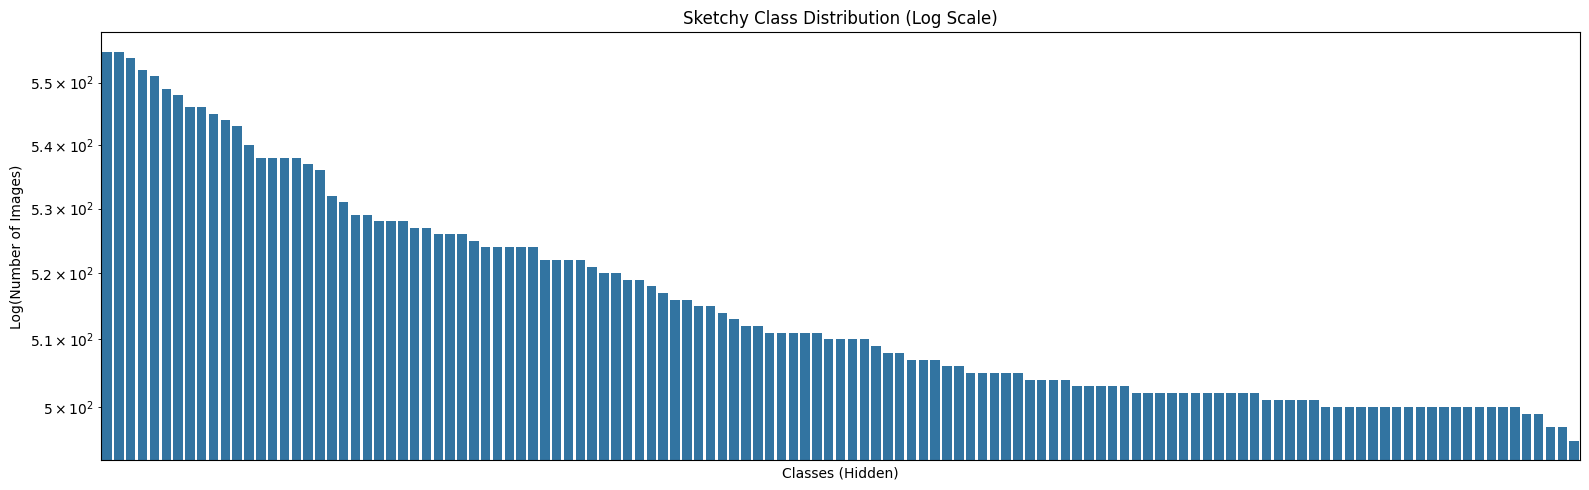


Sample images from random classes:


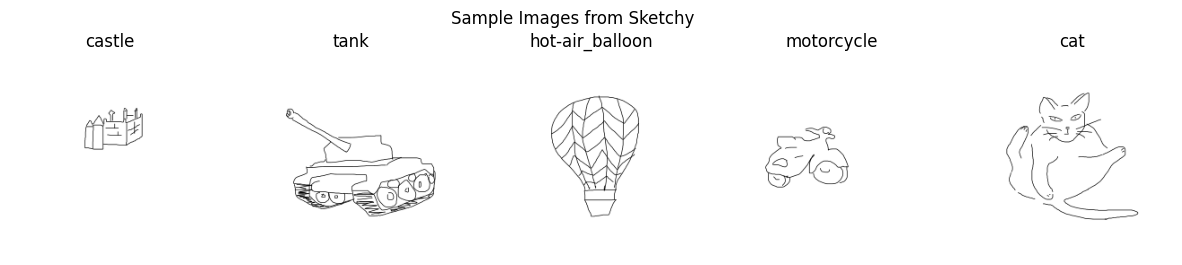


Visual variation in class: apple


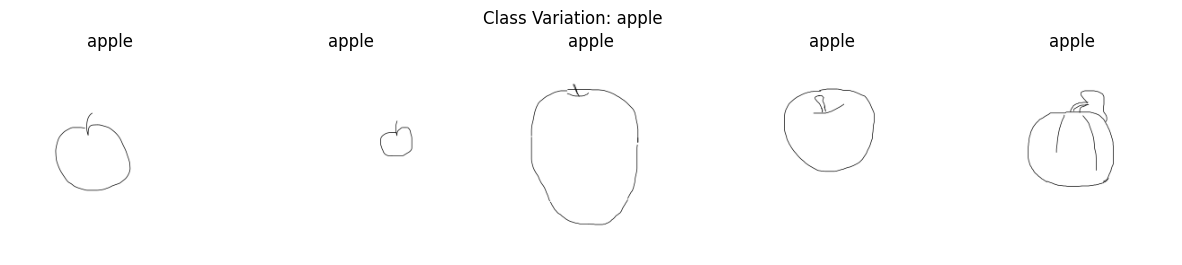


[INFO] EDA for TU-Berlin Dataset
Total Classes: 250
Total Images: 19999

Top 5 classes by image count:
         Class  Image Count
0     airplane           80
1  alarm clock           80
2        angel           80
3          ant           80
4        apple           80


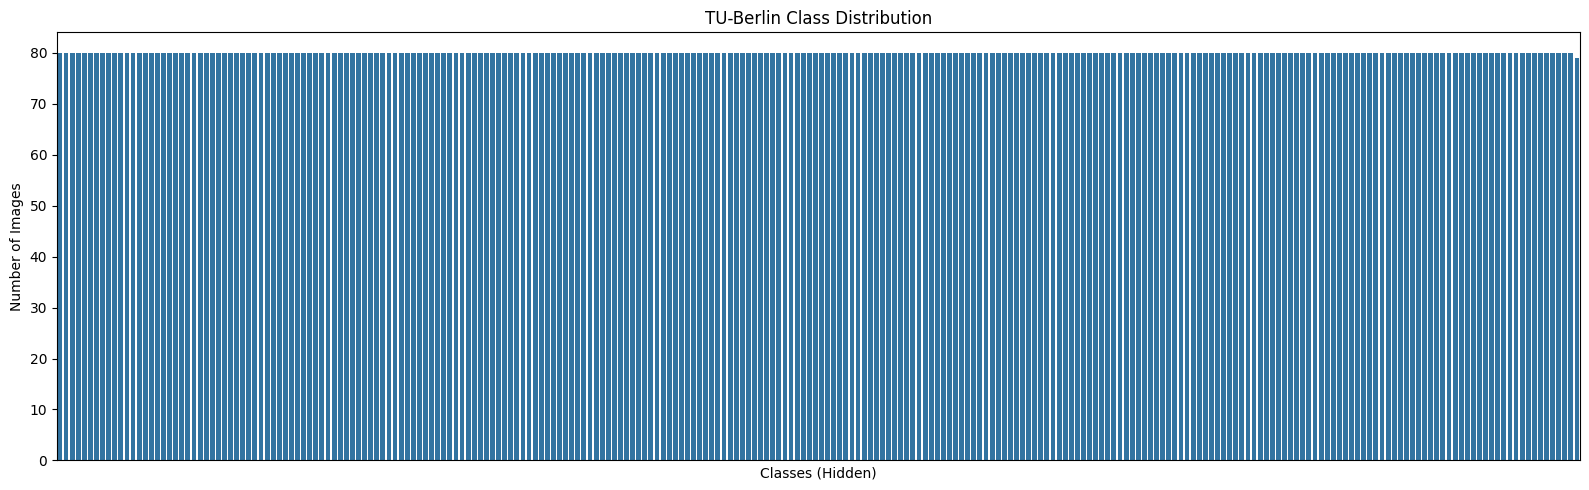

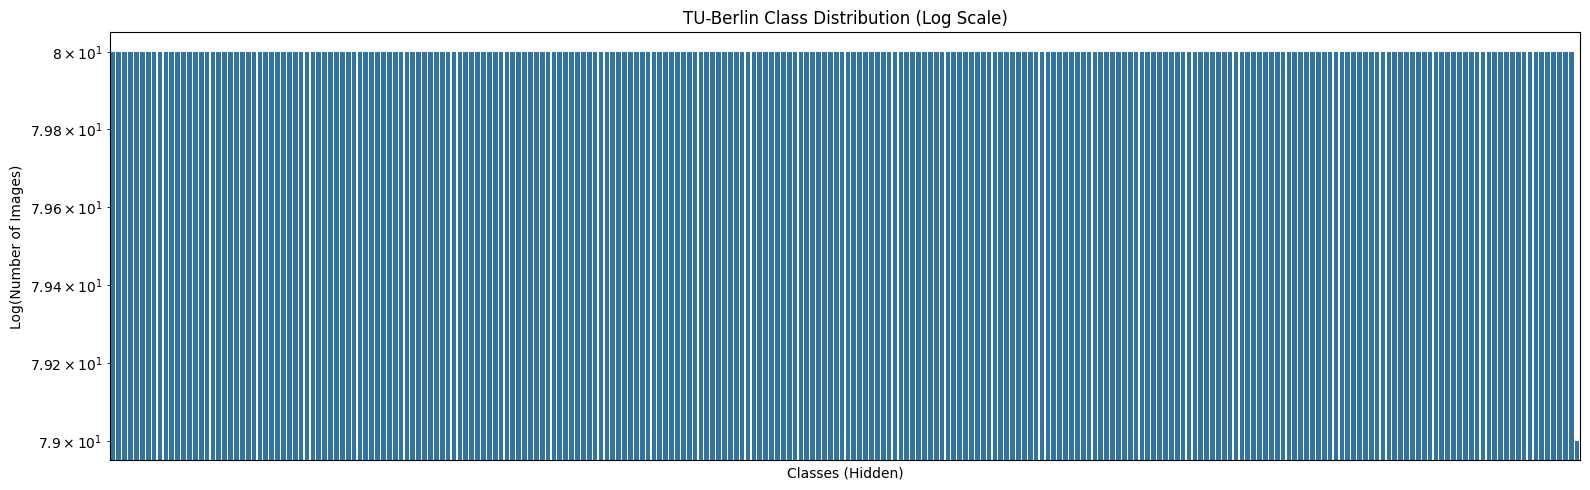


Sample images from random classes:


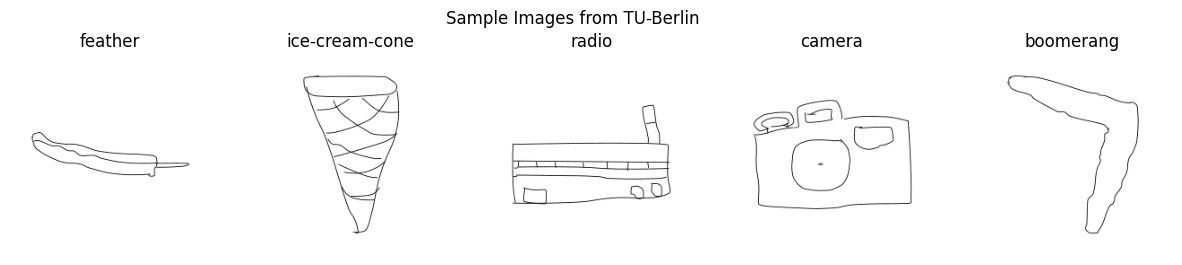


Visual variation in class: palm tree


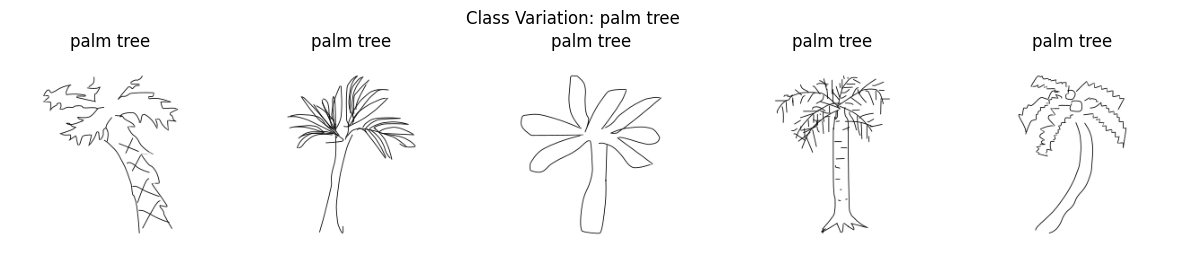

In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image
import seaborn as sns
import pandas as pd
import random


SKETCHY_DIR = "processed_sketchy"
TUBERLIN_DIR = "processed_tuberlin"

def analyze_dataset(dataset_path, dataset_name, show_variation_class=None):
    print(f"\n[INFO] EDA for {dataset_name} Dataset")

    # Load dataset structure
    dataset = datasets.ImageFolder(dataset_path)
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Count images per class
    class_counts = {}
    for _, label in dataset.samples:
        class_name = idx_to_class[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
    class_counts_df = class_counts_df.sort_values("Image Count", ascending=False)

    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {sum(class_counts.values())}")
    print("\nTop 5 classes by image count:")
    print(class_counts_df.head())

    # Plot regular class distribution (hidden xticks)
    plt.figure(figsize=(16, 5))
    sns.barplot(data=class_counts_df, x='Class', y='Image Count')
    plt.title(f"{dataset_name} Class Distribution")
    plt.xticks([], [])
    plt.ylabel("Number of Images")
    plt.xlabel("Classes (Hidden)")
    plt.tight_layout()
    plt.show()

    # Plot log-scaled class distribution
    plt.figure(figsize=(16, 5))
    sns.barplot(data=class_counts_df, x='Class', y='Image Count')
    plt.yscale('log')
    plt.title(f"{dataset_name} Class Distribution (Log Scale)")
    plt.xticks([], [])
    plt.ylabel("Log(Number of Images)")
    plt.xlabel("Classes (Hidden)")
    plt.tight_layout()
    plt.show()

    # Sample images
    print("\nSample images from random classes:")
    sample_classes = random.sample(list(class_counts.keys()), 5)
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, class_name in enumerate(sample_classes):
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.endswith(".png")]
        image_path = os.path.join(class_dir, random.choice(image_files))
        img = Image.open(image_path)
        axs[i].imshow(img)
        axs[i].set_title(class_name)
        axs[i].axis('off')
    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.show()

    # Visual variation within a selected class
    if show_variation_class and show_variation_class in class_counts:
        print(f"\nVisual variation in class: {show_variation_class}")
        class_dir = os.path.join(dataset_path, show_variation_class)
        image_files = [f for f in os.listdir(class_dir) if f.endswith(".png")]
        image_files = random.sample(image_files, min(5, len(image_files)))

        fig, axs = plt.subplots(1, len(image_files), figsize=(15, 3))
        for i, file in enumerate(image_files):
            img = Image.open(os.path.join(class_dir, file))
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(f"{show_variation_class}")
        plt.suptitle(f"Class Variation: {show_variation_class}")
        plt.show()
    elif show_variation_class:
        print(f"[WARNING] Class '{show_variation_class}' not found in dataset.")

    return class_counts_df


if __name__ == "__main__":
    sketchy_stats = analyze_dataset(SKETCHY_DIR, "Sketchy", show_variation_class="apple")
    tuberlin_stats = analyze_dataset(TUBERLIN_DIR, "TU-Berlin", show_variation_class="palm tree")


# Training

In [ ]:
!pip install faiss-gpu-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## Train Model(RankSVM + FAISS)

In [ ]:
import os
import torch
import faiss
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
from sklearn.preprocessing import StandardScaler
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

# Paths
DATA_DIR = "processed_tuberlin"
IMG_SIZE = 224
EMBED_DIM = 512  # Output size of CLIP ViT-B/32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP model and processor
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(device)

# Load image paths and labels
def load_images_and_labels(data_dir):
    X, y = [], []
    class_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    for class_name in tqdm(class_dirs, desc="Loading images"):
        class_path = os.path.join(data_dir, class_name)
        for file in os.listdir(class_path):
            if not file.lower().endswith(".png"):
                continue
            img_path = os.path.join(class_path, file)
            X.append(img_path)
            y.append(class_name)
    return X, y

# Extract CLIP features
def extract_clip_features(image_paths):
    all_embeddings = []
    for i in tqdm(range(0, len(image_paths), 32), desc="Extracting CLIP embeddings"):
        batch_paths = image_paths[i:i+32]
        images = [Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE)) for p in batch_paths]
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
            outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # L2 normalize
        all_embeddings.append(outputs.cpu().numpy())
    return np.vstack(all_embeddings)

# Apply PCA
def apply_pca(X, n_components=128):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

# Train RankSVM
def train_ranksvm(X_train, y_train):
    clf = SVC(kernel="rbf", probability=True)
    clf.fit(X_train, y_train)
    return clf

# Build FAISS index
def build_faiss_index(embeddings):
    index = faiss.IndexFlatIP(embeddings.shape[1])
    faiss.normalize_L2(embeddings)
    index.add(embeddings.astype(np.float32))
    return index

# Evaluate top-k accuracy
def evaluate_top_k(clf, X_test, y_test, label_encoder, k_list=[1, 2, 3, 4, 5]):
    y_probs = clf.predict_proba(X_test)
    y_true_enc = label_encoder.transform(y_test)
    for k in k_list:
        acc = top_k_accuracy_score(y_true_enc, y_probs, k=k, labels=range(len(label_encoder.classes_)))
        print(f"Top-{k} Accuracy: {acc:.4f}")

# Evaluate Mean Average Precision
def evaluate_map(clf, X_test, y_test, label_encoder):
    y_probs = clf.predict_proba(X_test)
    y_true_enc = label_encoder.transform(y_test)
    y_true_bin = np.eye(len(label_encoder.classes_))[y_true_enc]
    mAP = average_precision_score(y_true_bin, y_probs, average='macro')
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Evaluate FAISS Index
def evaluate_faiss(index, X_test, y_test, y_train_labels, label_encoder, k_list=[1, 2, 3, 4, 5]):
    print("[INFO] Evaluating FAISS retrieval...")
    faiss.normalize_L2(X_test.astype(np.float32))
    D, I = index.search(X_test.astype(np.float32), max(k_list))

    y_test_enc = label_encoder.transform(y_test)
    y_train_enc = y_train_labels[I]

    for k in k_list:
        top_k_preds = y_train_enc[:, :k]
        correct = np.any(top_k_preds == y_test_enc[:, None], axis=1)
        acc = np.mean(correct)
        print(f"FAISS Top-{k} Retrieval Accuracy: {acc:.4f}")


# MAIN
if __name__ == "__main__":
    # 1. Load data
    image_paths, labels = load_images_and_labels(DATA_DIR)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # 2. Extract CLIP features
    clip_embeddings = extract_clip_features(image_paths)

    # 3. Apply PCA
    clip_pca, pca_model = apply_pca(clip_embeddings, n_components=256)

    # 4. Split train/test and Standard Scaler
    X_train, X_test, y_train, y_test = train_test_split(
        clip_pca, labels, test_size=0.2, stratify=labels, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 5. Train RankSVM
    print("[INFO] Training RankSVM...")
    rank_svm = train_ranksvm(X_train, y_train)

    # 6. Evaluate
    print("[INFO] Evaluating model...")
    evaluate_top_k(rank_svm, X_test, y_test, label_encoder)
    evaluate_map(rank_svm, X_test, y_test, label_encoder)

    # 7. Build and evaluate FAISS index for retrieval
    print("[INFO] Building FAISS index...")
    index = build_faiss_index(X_train)
    evaluate_faiss(index, X_test, y_test, label_encoder.transform(y_train), label_encoder)

    # 8. Save models and index
    print("[INFO] Saving model, encoder, PCA, and FAISS index...")
    os.makedirs("artifacts", exist_ok=True)
    joblib.dump(rank_svm, "artifacts/rank_svm.pkl")
    joblib.dump(pca_model, "artifacts/clip_pca.pkl")
    joblib.dump(label_encoder, "artifacts/label_encoder.pkl")
    joblib.dump(scaler, "artifacts/clip_scaler.pkl")
    faiss.write_index(index, "artifacts/clip_faiss.index")
    np.save("artifacts/faiss_labels.npy", label_encoder.transform(y_train))
    print("[INFO] All components saved.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Extracting CLIP embeddings:   0%|          | 0/625 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Extracting CLIP embeddings: 100%|██████████| 625/625 [01:57<00:00,  5.30it/s]


[INFO] Training RankSVM...
[INFO] Evaluating model...
Top-1 Accuracy: 0.7412
Top-2 Accuracy: 0.8492
Top-3 Accuracy: 0.8878
Top-4 Accuracy: 0.9105
Top-5 Accuracy: 0.9240
Mean Average Precision (mAP): 0.7924
[INFO] Building FAISS index...
[INFO] Evaluating FAISS retrieval...
FAISS Top-1 Retrieval Accuracy: 0.6605
FAISS Top-2 Retrieval Accuracy: 0.7548
FAISS Top-3 Retrieval Accuracy: 0.7995
FAISS Top-4 Retrieval Accuracy: 0.8265
FAISS Top-5 Retrieval Accuracy: 0.8433
[INFO] Saving model, encoder, PCA, and FAISS index...
[INFO] All components saved.


# Testing

## Baseline Model (VGG-16)

### Testing on Sketchy after two stage fine tuning

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Config
SKETCHY_DIR = "processed_sketchy"
MODEL_PATH = "vgg16_tuberlin_stage2.pth"
NUM_CLASSES = 250
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# label mapping
TUBERLIN_CLASSES = sorted(os.listdir("processed_tuberlin"))
TUBERLIN_CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(TUBERLIN_CLASSES)}

# Filter Sketchy
overlap_classes = [cls for cls in os.listdir(SKETCHY_DIR) if cls in TUBERLIN_CLASS_TO_IDX]
print(f"[INFO] Overlapping classes: {len(overlap_classes)}")


class MappedSketchyDataset(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [cls for cls in os.listdir(directory) if cls in TUBERLIN_CLASS_TO_IDX]
        classes.sort()
        class_to_idx = {cls_name: TUBERLIN_CLASS_TO_IDX[cls_name] for cls_name in classes}
        return classes, class_to_idx

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset and Dataloader
dataset = MappedSketchyDataset(SKETCHY_DIR, transform=transform)

_, test_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=42
)

test_set = torch.utils.data.Subset(dataset, test_idx)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Top-k accuracy
def compute_topk_accuracy(model, dataloader, k=(1, 2, 3, 4, 5)):
    correct = {i: 0 for i in k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing Sketchy with Final Model"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = outputs.topk(max(k), dim=1, largest=True, sorted=True)

            for topk in k:
                correct_preds = preds[:, :topk].eq(labels.view(-1, 1).expand_as(preds[:, :topk]))
                correct[topk] += correct_preds.sum().item()
            total += labels.size(0)

    print("\n[Sketchy→Final Model] Top-k Accuracy:")
    for topk in k:
        acc = correct[topk] / total
        print(f"Top-{topk} Accuracy: {acc:.4f}")

compute_topk_accuracy(model, test_loader)


[INFO] Overlapping classes: 84


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing Sketchy with Final Model: 10


[Sketchy→Final Model] Top-k Accuracy:
Top-1 Accuracy: 0.4510
Top-2 Accuracy: 0.5755
Top-3 Accuracy: 0.6459
Top-4 Accuracy: 0.6919
Top-5 Accuracy: 0.7265


### Testing on TU-Berlin

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Config
DATA_DIR = "processed_tuberlin"
MODEL_PATH = "vgg16_tuberlin_stage2.pth"
BATCH_SIZE = 32
NUM_CLASSES = 250
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset and DataLoader
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes


from sklearn.model_selection import train_test_split
test_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets, random_state=42)[1]
test_set = torch.utils.data.Subset(dataset, test_idx)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Load model
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Top-k accuracy function
def compute_topk_accuracy(model, dataloader, k=(1, 2, 3, 4, 5)):
    correct = {i: 0 for i in k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = outputs.topk(max(k), dim=1, largest=True, sorted=True)

            for topk in k:
                correct_preds = preds[:, :topk].eq(labels.view(-1, 1).expand_as(preds[:, :topk]))
                correct[topk] += correct_preds.sum().item()
            total += labels.size(0)

    print("\nTop-k Accuracy Results:")
    for topk in k:
        acc = correct[topk] / total
        print(f"Top-{topk} Accuracy: {acc:.4f}")

compute_topk_accuracy(model, test_loader)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 125/125 [0


Top-k Accuracy Results:
Top-1 Accuracy: 0.6670
Top-2 Accuracy: 0.7812
Top-3 Accuracy: 0.8305
Top-4 Accuracy: 0.8575
Top-5 Accuracy: 0.8782


## Proposed Model

[INFO] Loading model artifacts...
[INFO] Upload an image sketch (any format)...


Saving skyscrapper.jpg to skyscrapper.jpg


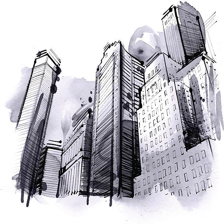


🔀 Final Combined Top-5 Predictions (RankSVM + FAISS):
1. skyscraper (0.6137)
2. santa claus (0.0320)
3. face (0.0154)
4. head (0.0151)
5. angel (0.0129)


In [ ]:
import torch
import numpy as np
from PIL import Image
import faiss
import joblib
import io
import os
from collections import defaultdict
from scipy.special import softmax

from google.colab import files
from IPython.display import display
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

# Constants
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ARTIFACT_DIR = "artifacts"
TOP_K = 5
ALPHA = 0.4   # 40% RankSVM 60% FAISS

# Load model artifacts
print("[INFO] Loading model artifacts...")
rank_svm = joblib.load(f"{ARTIFACT_DIR}/rank_svm.pkl")
pca = joblib.load(f"{ARTIFACT_DIR}/clip_pca.pkl")
scaler = joblib.load(f"{ARTIFACT_DIR}/clip_scaler.pkl")
label_encoder = joblib.load(f"{ARTIFACT_DIR}/label_encoder.pkl")
faiss_index = faiss.read_index(f"{ARTIFACT_DIR}/clip_faiss.index")
faiss_labels = np.load(f"{ARTIFACT_DIR}/faiss_labels.npy")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = AutoModelForZeroShotImageClassification.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(DEVICE)

# Upload image
print("[INFO] Upload an image sketch (any format)...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Convert to PNG and resize
image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
image = image.resize((IMG_SIZE, IMG_SIZE))
display(image)

# Preprocess and extract CLIP features
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    clip_feat = clip_model.get_image_features(**inputs)
    clip_feat = clip_feat / clip_feat.norm(p=2, dim=-1, keepdim=True)

clip_np = clip_feat.cpu().numpy()

# Apply PCA and scaling
clip_pca = pca.transform(clip_np)
clip_scaled = scaler.transform(clip_pca)

# RankSVM Prediction
probs = rank_svm.predict_proba(clip_scaled)[0]
top_indices = np.argsort(probs)[::-1][:TOP_K]
top_labels = label_encoder.inverse_transform(top_indices)
top_scores = probs[top_indices]

# print(f"\n🎯 RankSVM Top-{TOP_K} Predictions:")
# for i in range(TOP_K):
#     print(f"{i+1}. {top_labels[i]} ({top_scores[i]:.4f})")

# FAISS Nearest Neighbors
faiss.normalize_L2(clip_scaled.astype(np.float32))
search_k = TOP_K * 5
D, I = faiss_index.search(clip_scaled.astype(np.float32), search_k)

# Get unique top-k labels and accumulated similarity scores
faiss_label_sim = defaultdict(float)
for idx, sim in zip(I[0], D[0]):
    if idx >= len(faiss_labels):
        continue
    label = label_encoder.inverse_transform([faiss_labels[idx]])[0]
    faiss_label_sim[label] += sim

faiss_labels_list = list(faiss_label_sim.keys())
faiss_sims = np.array([faiss_label_sim[l] for l in faiss_labels_list])
faiss_probs = softmax(faiss_sims)

# Create full probability array for all classes
faiss_full_probs = np.zeros(len(label_encoder.classes_))
for i, label in enumerate(faiss_labels_list):
    idx = np.where(label_encoder.classes_ == label)[0][0]
    faiss_full_probs[idx] = faiss_probs[i]

# Print unique FAISS neighbors
# print(f"\n🔎 FAISS Nearest Neighbors (Top {TOP_K} unique):")
# seen_labels = set()
# unique_neighbors = []
# for idx, sim in zip(I[0], D[0]):
#     if idx >= len(faiss_labels):
#         continue
#     label = label_encoder.inverse_transform([faiss_labels[idx]])[0]
#     if label not in seen_labels:
#         seen_labels.add(label)
#         unique_neighbors.append((label, sim))
#         if len(unique_neighbors) == TOP_K:
#             break

# if len(unique_neighbors) < TOP_K:
#     print(f"[WARNING] Only found {len(unique_neighbors)} unique neighbors.")

# for i, (label, sim) in enumerate(unique_neighbors):
#     print(f"{i+1}. {label} (Similarity: {sim:.4f})")

# Combine RankSVM and FAISS predictions
combined_probs = ALPHA * probs + (1 - ALPHA) * faiss_full_probs
top_combined_indices = np.argsort(combined_probs)[::-1][:TOP_K]
top_combined_labels = label_encoder.inverse_transform(top_combined_indices)
top_combined_scores = combined_probs[top_combined_indices]

print(f"\n🔀 Final Combined Top-{TOP_K} Predictions (RankSVM + FAISS):")
for i in range(TOP_K):
    print(f"{i+1}. {top_combined_labels[i]} ({top_combined_scores[i]:.4f})")


### Testing on sketchy dataset

In [ ]:
import os
import random
import torch
import numpy as np
from PIL import Image
import faiss
import joblib
from collections import defaultdict, Counter
from tqdm import tqdm
from scipy.special import softmax
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

# Constants
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ARTIFACT_DIR = "artifacts"
DATASET_DIR = "processed_sketchy"
SAMPLE_RATIO = 0.2  # 20% per class
TOP_K = 5
ALPHA = 0.4  # static alpha

# Load model artifacts
print("[INFO] Loading model artifacts...")
rank_svm = joblib.load(f"{ARTIFACT_DIR}/rank_svm.pkl")
pca = joblib.load(f"{ARTIFACT_DIR}/clip_pca.pkl")
scaler = joblib.load(f"{ARTIFACT_DIR}/clip_scaler.pkl")
label_encoder = joblib.load(f"{ARTIFACT_DIR}/label_encoder.pkl")
faiss_index = faiss.read_index(f"{ARTIFACT_DIR}/clip_faiss.index")
faiss_labels = np.load(f"{ARTIFACT_DIR}/faiss_labels.npy")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = AutoModelForZeroShotImageClassification.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(DEVICE)

# Accuracy tracker
topk_hits = Counter({k: 0 for k in range(1, TOP_K + 1)})
total_samples = 0

def get_combined_prediction(image):
    image = image.resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        clip_feat = clip_model.get_image_features(**inputs)
        clip_feat = clip_feat / clip_feat.norm(p=2, dim=-1, keepdim=True)

    clip_np = clip_feat.cpu().numpy()
    clip_pca = pca.transform(clip_np)
    clip_scaled = scaler.transform(clip_pca)

    # RankSVM
    probs = rank_svm.predict_proba(clip_scaled)[0]

    # FAISS
    faiss.normalize_L2(clip_scaled.astype(np.float32))
    D, I = faiss_index.search(clip_scaled.astype(np.float32), TOP_K * 5)
    faiss_label_sim = defaultdict(float)
    for idx, sim in zip(I[0], D[0]):
        if idx >= len(faiss_labels):
            continue
        label = label_encoder.inverse_transform([faiss_labels[idx]])[0]
        faiss_label_sim[label] += sim

    faiss_labels_list = list(faiss_label_sim.keys())
    faiss_sims = np.array([faiss_label_sim[l] for l in faiss_labels_list])
    faiss_probs = softmax(faiss_sims)
    faiss_full_probs = np.zeros(len(label_encoder.classes_))
    for i, label in enumerate(faiss_labels_list):
        idx = np.where(label_encoder.classes_ == label)[0][0]
        faiss_full_probs[idx] = faiss_probs[i]

    combined_probs = ALPHA * probs + (1 - ALPHA) * faiss_full_probs
    top_combined_indices = np.argsort(combined_probs)[::-1][:TOP_K]
    top_combined_labels = label_encoder.inverse_transform(top_combined_indices)
    return top_combined_labels

print(f"[INFO] Evaluating on 20% sampled dataset per class in: {DATASET_DIR}")
for class_name in tqdm(os.listdir(DATASET_DIR), desc="Classes"):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_size = max(1, int(SAMPLE_RATIO * len(image_files)))
    sampled_files = random.sample(image_files, sample_size)

    for img_file in tqdm(sampled_files, desc=f"Testing class '{class_name}'", leave=False):
        img_path = os.path.join(class_path, img_file)
        try:
            image = Image.open(img_path)
            top_preds = get_combined_prediction(image)

            # Skip unknown labels
            if class_name not in label_encoder.classes_:
                continue

            total_samples += 1
            for k in range(1, TOP_K + 1):
                if class_name in top_preds[:k]:
                    topk_hits[k] += 1
        except Exception as e:
            print(f"[ERROR] Failed to process {img_path}: {e}")

print(f"\n📊 Top-K Accuracy Results on {total_samples} samples:")
for k in range(1, TOP_K + 1):
    acc = topk_hits[k] / total_samples if total_samples > 0 else 0
    print(f"Top-{k} Accuracy: {acc:.4f}")


[INFO] Loading model artifacts...
[INFO] Evaluating on 20% sampled dataset per class in: processed_sketchy


Streaming output truncated to the last 5000 lines.
Classes: 100%|██████████| 125/125 [12:52<00:00,  6.18s/it]


📊 Top-K Accuracy Results on 8648 samples:
Top-1 Accuracy: 0.6249
Top-2 Accuracy: 0.7301
Top-3 Accuracy: 0.7700
Top-4 Accuracy: 0.7945
Top-5 Accuracy: 0.8121


### Testing on TU Berlin (Combined)

In [ ]:
import os
import random
import torch
import numpy as np
from PIL import Image
import faiss
import joblib
from collections import defaultdict, Counter
from tqdm import tqdm
from scipy.special import softmax
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

# Constants
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ARTIFACT_DIR = "artifacts"
DATASET_DIR = "processed_tuberlin"
SAMPLE_RATIO = 0.2  # 20% per class
TOP_K = 5
ALPHA = 0.4  # static alpha

# Load model artifacts
print("[INFO] Loading model artifacts...")
rank_svm = joblib.load(f"{ARTIFACT_DIR}/rank_svm.pkl")
pca = joblib.load(f"{ARTIFACT_DIR}/clip_pca.pkl")
scaler = joblib.load(f"{ARTIFACT_DIR}/clip_scaler.pkl")
label_encoder = joblib.load(f"{ARTIFACT_DIR}/label_encoder.pkl")
faiss_index = faiss.read_index(f"{ARTIFACT_DIR}/clip_faiss.index")
faiss_labels = np.load(f"{ARTIFACT_DIR}/faiss_labels.npy")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = AutoModelForZeroShotImageClassification.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(DEVICE)

# Accuracy tracker
topk_hits = Counter({k: 0 for k in range(1, TOP_K + 1)})
total_samples = 0

def get_combined_prediction(image):
    image = image.resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        clip_feat = clip_model.get_image_features(**inputs)
        clip_feat = clip_feat / clip_feat.norm(p=2, dim=-1, keepdim=True)

    clip_np = clip_feat.cpu().numpy()
    clip_pca = pca.transform(clip_np)
    clip_scaled = scaler.transform(clip_pca)

    # RankSVM
    probs = rank_svm.predict_proba(clip_scaled)[0]

    # FAISS
    faiss.normalize_L2(clip_scaled.astype(np.float32))
    D, I = faiss_index.search(clip_scaled.astype(np.float32), TOP_K * 5)
    faiss_label_sim = defaultdict(float)
    for idx, sim in zip(I[0], D[0]):
        if idx >= len(faiss_labels):
            continue
        label = label_encoder.inverse_transform([faiss_labels[idx]])[0]
        faiss_label_sim[label] += sim

    faiss_labels_list = list(faiss_label_sim.keys())
    faiss_sims = np.array([faiss_label_sim[l] for l in faiss_labels_list])
    faiss_probs = softmax(faiss_sims)
    faiss_full_probs = np.zeros(len(label_encoder.classes_))
    for i, label in enumerate(faiss_labels_list):
        idx = np.where(label_encoder.classes_ == label)[0][0]
        faiss_full_probs[idx] = faiss_probs[i]

    combined_probs = ALPHA * probs + (1 - ALPHA) * faiss_full_probs
    top_combined_indices = np.argsort(combined_probs)[::-1][:TOP_K]
    top_combined_labels = label_encoder.inverse_transform(top_combined_indices)
    return top_combined_labels

print(f"[INFO] Evaluating on 20% sampled dataset per class in: {DATASET_DIR}")
for class_name in tqdm(os.listdir(DATASET_DIR), desc="Classes"):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_size = max(1, int(SAMPLE_RATIO * len(image_files)))
    sampled_files = random.sample(image_files, sample_size)

    for img_file in tqdm(sampled_files, desc=f"Testing class '{class_name}'", leave=False):
        img_path = os.path.join(class_path, img_file)
        try:
            image = Image.open(img_path)
            top_preds = get_combined_prediction(image)

            # Skip unknown labels
            if class_name not in label_encoder.classes_:
                continue

            total_samples += 1
            for k in range(1, TOP_K + 1):
                if class_name in top_preds[:k]:
                    topk_hits[k] += 1
        except Exception as e:
            print(f"[ERROR] Failed to process {img_path}: {e}")

print(f"\n📊 Top-K Accuracy Results on {total_samples} samples:")
for k in range(1, TOP_K + 1):
    acc = topk_hits[k] / total_samples if total_samples > 0 else 0
    print(f"Top-{k} Accuracy: {acc:.4f}")


[INFO] Loading model artifacts...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO] Evaluating on 20% sampled dataset per class in: processed_tuberlin



Classes:   0%|          | 0/250 [00:00<?, ?it/s]

Testing class 'socks':   0%|          | 0/16 [00:00<?, ?it/s]

Testing class 'socks':   6%|▋         | 1/16 [00:03<00:46,  3.13s/it]

Testing class 'socks':  19%|█▉        | 3/16 [00:03<00:11,  1.16it/s]

Testing class 'socks':  31%|███▏      | 5/16 [00:03<00:05,  2.15it/s]

Testing class 'socks':  44%|████▍     | 7/16 [00:03<00:02,  3.28it/s]

Testing class 'socks':  56%|█████▋    | 9/16 [00:03<00:01,  4.54it/s]

Testing class 'socks':  69%|██████▉   | 11/16 [00:03<00:00,  5.77it/s]

Testing class 'socks':  81%|████████▏ | 13/16 [00:04<00:00,  6.86it/s]

Testing class 'socks':  94%|█████████▍| 15/16 [00:04<00:00,  8.13it/s]

                                                                      
                                                                         
                                                                      
                                                                       
                           


📊 Top-K Accuracy Results on 3999 samples:
Top-1 Accuracy: 0.7724
Top-2 Accuracy: 0.9582
Top-3 Accuracy: 0.9752
Top-4 Accuracy: 0.9795
Top-5 Accuracy: 0.9842
